# Model Learning
전처리된 data를 가지고 모델에 넣어 학습시키는 부분이다.

학습 모델로는 회귀 모델을 사용하였으며, 최적의 값을 구하기 위해 optuna 기능을 추가하여 최적의 parameter를 구했다.

각 model에 대한 optuna를 진행한 이후, voting기능을 사용하여 예상 최적 값을 구하고 이를 시각화 시킨다.

# 1. Library upload

In [3]:
# 회귀 모델 중 하나인 CatBoost model을 사용하기 위해 pip 을 통해 설치
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 5.6 MB/s eta 0:00:00


In [1]:
# optuna 기능을 사용하기 위한 설치 code
!pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 22.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 8.9 MB/s eta 0:00:00


In [4]:
# model 학습 및 시각화하는데 필요한 library upload
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, VotingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from catboost import CatBoostRegressor
import optuna
from optuna import trial
from optuna.samplers import TPESampler
import matplotlib.pyplot as plt
import numpy as np

# 2. Train-Valid Split

In [5]:
# train, vaild split
train = pd.read_csv('/content/train_data.csv')
test = pd.read_csv('/content/test_data.csv')

x = train[['Temp(K)', 'Mass(sun=1)','Spec_Encoded','MMK_Encoded']]
y = train['end_Type_Encoded']
x_test = test[['Temp(K)', 'Mass(sun=1)', 'Spec_Encoded','MMK_Encoded']]
y_test = test[['end_Type_Encoded']]
X_train, X_valid, Y_train, Y_valid = train_test_split(x, y, test_size=0.3, shuffle=True, random_state=42) # train:valid = 7:3 의 비율로 split

# 크기 확인
print(x.shape, y.shape)
print(x_test.shape, y_test.shape)

(4532, 4) (4532,)
(832, 4) (832, 1)


# 3. Model 학습

optuna는 python기반 hyper-parameter 최적화를 자동으로 해주는 프레임 워크이다.


study와 trial을 통해 trial함수에서 목적함수를 시행할 횟수를 정하면 study에서 그 횟수만큼 반복하여 최적화 과정을 진행한다.



이런 과정을 반복하면서 최적의 하이터파라미터 조합을 찾는것이다.

In [ ]:
# decision tree regressor
DT_model = DecisionTreeRegressor(max_depth=186, min_samples_split=8, min_samples_leaf=2)
DT_model.fit(X_train, Y_train)

pred = DT_model.predict(x_test)
pred

# 평가지표(mae, mse, R)
mae = mean_absolute_error(y_test, pred)
mse = mean_squared_error(y_test, pred)
r2 = r2_score(y_test, pred)

print(f'Mean Absolute Error: {mae}')
print(f'Mean Squared Error: {mse}')
print(f'R2 Score: {r2}')

Mean Absolute Error: 1.1683092948717948
Mean Squared Error: 3.4107144764957265
R2 Score: -1.78011068471629


In [ ]:
# optuna 적용
# Objective 함수
def objectiveDT(trial):
    try:
        param = {
            'max_depth': trial.suggest_int('max_depth', 50, 200),
            'random_state': 42,
            'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
            'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20)
        }

        model = DecisionTreeRegressor(**param)
        model.fit(X_train, Y_train)
        pred = model.predict(x_test)

        mae = mean_absolute_error(y_test, pred)
        return mae

    except Exception as e:
        print(f'Error in trial {trial.number}: {e}')
        return float('inf')

sampler = TPESampler(seed=42)
study = optuna.create_study(
    study_name='dtm_parameter_opt',
    direction='minimize',
    sampler=sampler
)

# 최적화 실행 및 예외 처리
try:
    study.optimize(objectiveDT, n_trials=100)
except Exception as e:
    print(f'Optimization failed: {e}')

# 최적화 완료 여부 확인
if len(study.trials) == 0:
    print("No trials were completed.")
else:
    best_params = study.best_params
    print('Best Parameters:', best_params)

    # 최적의 하이퍼파라미터로 모델 학습
    best_model = DecisionTreeRegressor(**best_params, random_state=42)
    best_model.fit(X_train, Y_train)
    pred = best_model.predict(x_test)

    # 평가지표(mae, mse, R2)
    mae = mean_absolute_error(y_test, pred)
    mse = mean_squared_error(y_test, pred)
    r2 = r2_score(y_test, pred)

    print(f'Mean Absolute Error: {mae}')
    print(f'Mean Squared Error: {mse}')
    print(f'R2 Score: {r2}')

[I 2024-06-08 17:57:42,097] A new study created in memory with name: dtm_parameter_opt
[I 2024-06-08 17:57:42,116] Trial 0 finished with value: 1.280105535316133 and parameters: {'max_depth': 106, 'min_samples_split': 20, 'min_samples_leaf': 15}. Best is trial 0 with value: 1.280105535316133.
[I 2024-06-08 17:57:42,132] Trial 1 finished with value: 1.18984375 and parameters: {'max_depth': 140, 'min_samples_split': 4, 'min_samples_leaf': 4}. Best is trial 1 with value: 1.18984375.
[I 2024-06-08 17:57:42,151] Trial 2 finished with value: 1.2809481544096928 and parameters: {'max_depth': 58, 'min_samples_split': 18, 'min_samples_leaf': 13}. Best is trial 1 with value: 1.18984375.
[I 2024-06-08 17:57:42,170] Trial 3 finished with value: 1.2950898848573391 and parameters: {'max_depth': 156, 'min_samples_split': 2, 'min_samples_leaf': 20}. Best is trial 1 with value: 1.18984375.
[I 2024-06-08 17:57:42,191] Trial 4 finished with value: 1.18984375 and parameters: {'max_depth': 175, 'min_samples

Best Parameters: {'max_depth': 186, 'min_samples_split': 8, 'min_samples_leaf': 2}
Mean Absolute Error: 1.155088141025641
Mean Squared Error: 3.3446087072649573
R2 Score: -1.7262271489860659


In [ ]:
# random forest regressor
RF_model = RandomForestRegressor(max_depth=50, random_state=200)
RF_model.fit(X_train, Y_train)

pred1 = RF_model.predict(x_test)
pred1

# 평가지표(mae, mse, R)
mae = mean_absolute_error(y_test, pred1)
mse = mean_squared_error(y_test, pred1)
r2 = r2_score(y_test, pred1)

print(f'Mean Absolute Error: {mae}')
print(f'Mean Squared Error: {mse}')
print(f'R2 Score: {r2}')

RandomForestRegressor(max_depth=50, random_state=200)

In [ ]:
# optuna 적용
# Objective 함수
def objectiveRF(trial):
    try:
        param = {
            'max_depth': trial.suggest_int('max_depth', 50, 200),
            'random_state': 42,
            'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
            'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20)
        }

        model = RandomForestRegressor(**param)
        model.fit(X_train, Y_train)
        pred = model.predict(x_test)

        mae = mean_absolute_error(y_test, pred)
        return mae

    except Exception as e:
        print(f'Error in trial {trial.number}: {e}')
        return float('inf')

sampler = TPESampler(seed=42)
study = optuna.create_study(
    study_name='dtm_parameter_opt',
    direction='minimize',
    sampler=sampler
)

# 최적화 실행 및 예외 처리
try:
    study.optimize(objectiveRF, n_trials=100)
except Exception as e:
    print(f'Optimization failed: {e}')

# 최적화 완료 여부 확인
if len(study.trials) == 0:
    print("No trials were completed.")
else:
    best_params = study.best_params
    print('Best Parameters:', best_params)

    # 최적의 하이퍼파라미터로 모델 학습
    best_model = RandomForestRegressor(**best_params, random_state=42)
    best_model.fit(X_train, Y_train)
    pred1 = best_model.predict(x_test)

    # 평가지표(mae, mse, R2)
    mae = mean_absolute_error(y_test, pred1)
    mse = mean_squared_error(y_test, pred1)
    r2 = r2_score(y_test, pred1)

    print(f'Mean Absolute Error: {mae}')
    print(f'Mean Squared Error: {mse}')
    print(f'R2 Score: {r2}')

[I 2024-06-08 17:21:21,226] A new study created in memory with name: dtm_parameter_opt
[I 2024-06-08 17:21:21,688] Trial 0 finished with value: 1.2877221705796542 and parameters: {'max_depth': 106, 'min_samples_split': 20, 'min_samples_leaf': 15}. Best is trial 0 with value: 1.2877221705796542.
[I 2024-06-08 17:21:22,136] Trial 1 finished with value: 1.250652340047773 and parameters: {'max_depth': 140, 'min_samples_split': 4, 'min_samples_leaf': 4}. Best is trial 1 with value: 1.250652340047773.
[I 2024-06-08 17:21:22,584] Trial 2 finished with value: 1.2855207461187608 and parameters: {'max_depth': 58, 'min_samples_split': 18, 'min_samples_leaf': 13}. Best is trial 1 with value: 1.250652340047773.
[I 2024-06-08 17:21:23,003] Trial 3 finished with value: 1.2902695971251934 and parameters: {'max_depth': 156, 'min_samples_split': 2, 'min_samples_leaf': 20}. Best is trial 1 with value: 1.250652340047773.
[I 2024-06-08 17:21:23,458] Trial 4 finished with value: 1.250652340047773 and parame

Best Parameters: {'max_depth': 192, 'min_samples_split': 20, 'min_samples_leaf': 2}
Mean Absolute Error: 1.2064682894259735
Mean Squared Error: 3.3992807664556177
R2 Score: -1.770790942572083


In [ ]:
# cat boost regressor
CB_model = CatBoostRegressor(iterations=30, learning_rate=0.1, depth=5)
CB_model.fit(X_train, Y_train)

pred2 = CB_model.predict(X_valid)
pred2

# 평가지표(mae, mse, R)
mae = mean_absolute_error(y_test, pred2)
mse = mean_squared_error(y_test, pred2)
r2 = r2_score(y_test, pred2)

print(f'Mean Absolute Error: {mae}')
print(f'Mean Squared Error: {mse}')
print(f'R2 Score: {r2}')

0:	learn: 1.0285030	total: 47.2ms	remaining: 1.37s
1:	learn: 0.9370886	total: 48.9ms	remaining: 685ms
2:	learn: 0.8523821	total: 50.1ms	remaining: 451ms
3:	learn: 0.7797423	total: 51.2ms	remaining: 333ms
4:	learn: 0.7195142	total: 52.2ms	remaining: 261ms
5:	learn: 0.6581905	total: 53.3ms	remaining: 213ms
6:	learn: 0.6034773	total: 54.4ms	remaining: 179ms
7:	learn: 0.5578139	total: 55.6ms	remaining: 153ms
8:	learn: 0.5148038	total: 56.7ms	remaining: 132ms
9:	learn: 0.4769335	total: 57.7ms	remaining: 115ms
10:	learn: 0.4496522	total: 58.8ms	remaining: 102ms
11:	learn: 0.4199206	total: 60ms	remaining: 90ms
12:	learn: 0.3940630	total: 61.2ms	remaining: 80ms
13:	learn: 0.3711038	total: 62.3ms	remaining: 71.2ms
14:	learn: 0.3542600	total: 63.4ms	remaining: 63.4ms
15:	learn: 0.3388463	total: 64.6ms	remaining: 56.5ms
16:	learn: 0.3240725	total: 65.8ms	remaining: 50.3ms
17:	learn: 0.3115877	total: 67ms	remaining: 44.6ms
18:	learn: 0.3008926	total: 68.2ms	remaining: 39.5ms
19:	learn: 0.2908052	t

In [ ]:
# optuna 적용
# Objective 함수
def objectiveCB(trial):
        param = {
            'iterations': trial.suggest_int('iterations', 100, 1000),
            'depth': trial.suggest_int('depth', 4, 10),
            'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.3, log=True),
            'random_state': 42,
            'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 20),
            'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-3, 10.0, log=True)
        }

        model = CatBoostRegressor(**param)
        model.fit(X_train, Y_train, eval_set=(x_test, y_test), early_stopping_rounds=50, verbose=0)
        pred = model.predict(x_test)

        mae = mean_absolute_error(y_test, pred)
        return mae

sampler = TPESampler(seed=42)
study = optuna.create_study(
    study_name='cb_parameter_opt',
    direction='minimize',
    sampler=sampler
)

# 최적화 실행 및 예외 처리
try:
    study.optimize(objectiveCB, n_trials=100)
except Exception as e:
    print(f'Optimization failed: {e}')

# 최적화 완료 여부 확인
if len(study.trials) == 0:
    print("No trials were completed.")
else:
    best_params = study.best_params
    print('Best Parameters:', best_params)

    # 최적의 하이퍼파라미터로 모델 학습
    best_model = CatBoostRegressor(**best_params, random_state=42, verbose=0)
    best_model.fit(X_train, Y_train)
    pred2 = best_model.predict(x_test)

    # 평가지표(mae, mse, R2)
    mae = mean_absolute_error(y_test, pred2)
    mse = mean_squared_error(y_test, pred2)
    r2 = r2_score(y_test, pred2)

    print(f'Mean Absolute Error: {mae}')
    print(f'Mean Squared Error: {mse}')
    print(f'R2 Score: {r2}')

[I 2024-06-08 17:31:17,083] A new study created in memory with name: cb_parameter_opt
[I 2024-06-08 17:31:17,553] Trial 0 finished with value: 1.4502279853225173 and parameters: {'iterations': 437, 'depth': 10, 'learning_rate': 0.06504856968981275, 'min_data_in_leaf': 12, 'l2_leaf_reg': 0.004207988669606638}. Best is trial 0 with value: 1.4502279853225173.
[I 2024-06-08 17:31:17,639] Trial 1 finished with value: 1.4781606146197737 and parameters: {'iterations': 240, 'depth': 4, 'learning_rate': 0.13983740016490973, 'min_data_in_leaf': 13, 'l2_leaf_reg': 0.679657809075816}. Best is trial 0 with value: 1.4502279853225173.
[I 2024-06-08 17:31:18,057] Trial 2 finished with value: 1.4654711344989564 and parameters: {'iterations': 118, 'depth': 10, 'learning_rate': 0.11536162338241392, 'min_data_in_leaf': 5, 'l2_leaf_reg': 0.005337032762603957}. Best is trial 0 with value: 1.4502279853225173.
[I 2024-06-08 17:31:18,166] Trial 3 finished with value: 1.551212024157547 and parameters: {'iterati

Best Parameters: {'iterations': 900, 'depth': 8, 'learning_rate': 0.20166946388244217, 'min_data_in_leaf': 17, 'l2_leaf_reg': 0.043369655401102734}
Mean Absolute Error: 1.3161054336594717
Mean Squared Error: 3.4153879317862734
R2 Score: -1.7839200692535568


In [ ]:
# ada boost regressor
AB_model = AdaBoostRegressor(n_estimators=30, learning_rate=0.1, random_state=12)
AB_model.fit(X_train, Y_train)

pred3 = AB_model.predict(X_valid)
pred3

# 평가지표(mae, mse, R)
mae = mean_absolute_error(y_test, pred3)
mse = mean_squared_error(y_test, pred3)
r2 = r2_score(y_test, pred3)

print(f'Mean Absolute Error: {mae}')
print(f'Mean Squared Error: {mse}')
print(f'R2 Score: {r2}')

AdaBoostRegressor(learning_rate=0.1, n_estimators=30, random_state=12)

In [ ]:
# optuna 적용
# Objective 함수
def objectiveAB(trial):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0, log=True),
        'loss': trial.suggest_categorical('loss', ['linear', 'square', 'exponential']),
        'random_state': 42
    }

    model = AdaBoostRegressor(**param)
    model.fit(X_train, Y_train)
    pred = model.predict(x_test)

    mae = mean_absolute_error(y_test, pred)
    return mae

sampler = TPESampler(seed=42)
study = optuna.create_study(
    study_name='ab_parameter_opt',
    direction='minimize',
    sampler=sampler
)

# 최적화 실행 및 예외 처리
try:
    study.optimize(objectiveAB, n_trials=100)
except Exception as e:
    print(f'Optimization failed: {e}')

# 최적화 완료 여부 확인
if len(study.trials) == 0:
    print("No trials were completed.")
else:
    best_params = study.best_params
    print('Best Parameters:', best_params)

    # 최적의 하이퍼파라미터로 모델 학습
    best_model = AdaBoostRegressor(**best_params, random_state=42)
    best_model.fit(X_train, Y_train)
    pred = best_model.predict(x_test)

    # 평가지표(mae, mse, R2)
    mae = mean_absolute_error(y_test, pred)
    mse = mean_squared_error(y_test, pred)
    r2 = r2_score(y_test, pred)

    print(f'Mean Absolute Error: {mae}')
    print(f'Mean Squared Error: {mse}')
    print(f'R2 Score: {r2}')

[I 2024-06-08 17:34:20,960] A new study created in memory with name: ab_parameter_opt
[I 2024-06-08 17:34:21,131] Trial 0 finished with value: 1.367839697469596 and parameters: {'n_estimators': 218, 'learning_rate': 0.7969454818643931, 'loss': 'linear'}. Best is trial 0 with value: 1.367839697469596.
[I 2024-06-08 17:34:21,795] Trial 1 finished with value: 1.315875153215054 and parameters: {'n_estimators': 120, 'learning_rate': 0.01306673923805328, 'loss': 'linear'}. Best is trial 1 with value: 1.315875153215054.
[I 2024-06-08 17:34:21,888] Trial 2 finished with value: 1.462768994861863 and parameters: {'n_estimators': 59, 'learning_rate': 0.8706020878304853, 'loss': 'linear'}. Best is trial 1 with value: 1.315875153215054.
[I 2024-06-08 17:34:22,438] Trial 3 finished with value: 1.3365293800112765 and parameters: {'n_estimators': 132, 'learning_rate': 0.04059611610484305, 'loss': 'linear'}. Best is trial 1 with value: 1.315875153215054.
[I 2024-06-08 17:34:23,839] Trial 4 finished wit

Best Parameters: {'n_estimators': 128, 'learning_rate': 0.01733956870791962, 'loss': 'square'}
Mean Absolute Error: 1.3067086144528919
Mean Squared Error: 3.7386592926945976
R2 Score: -2.04742209228053


# 4. Voting regressor

앙상블 기법 중 하나로, 서로 다른 회귀 모델을 결합하여 예측 성능을 향상시키는 방법이다.

이를 통해 개별 모델의 약점을 보완하고, 예측 성능을 향상 시킬 수 있다.

In [9]:
# 각 모델에서 얻은 최적의 하이퍼파라미터
best_params_dt = {'max_depth': 186, 'min_samples_split': 8, 'min_samples_leaf': 2}
best_params_rf = {'max_depth': 192, 'min_samples_split': 20, 'min_samples_leaf': 2}
best_params_cb = {'iterations': 900, 'depth': 8, 'learning_rate': 0.2, 'min_data_in_leaf': 17, 'l2_leaf_reg': 0.04}
best_params_ab = {'n_estimators': 128, 'learning_rate': 0.02, 'loss': 'square'}

# RandomForestRegressor 생성
dt_model = DecisionTreeRegressor(**best_params_dt, random_state=42)

# DecisionTreeRegressor 생성
rf_model = RandomForestRegressor(**best_params_rf, random_state=42)

# AdaBoostRegressor 생성
cb_model = CatBoostRegressor(**best_params_cb, random_state=42)

# CatBoostRegressor 생성
ab_model = AdaBoostRegressor(**best_params_ab, random_state=42)

# VotingRegressor 생성
voting_model = VotingRegressor(estimators=[
    ('dt', dt_model),
    ('rf', rf_model),
    ('cb', cb_model),
    ('ab', ab_model)
])

# VotingRegressor 학습
voting_model.fit(X_train, Y_train)

# VotingRegressor 평가
pred = voting_model.predict(x_test)
mae = mean_absolute_error(y_test, pred)
mse = mean_squared_error(y_test, pred)
r2 = r2_score(y_test, pred)
print(f'Mean Absolute Error: {mae}')
print(f'Mean Squared Error: {mse}')
print(f'R2 Score: {r2}')

0:	learn: 0.9108894	total: 1.37ms	remaining: 1.24s
1:	learn: 0.7434909	total: 6.83ms	remaining: 3.07s
2:	learn: 0.6129783	total: 8.97ms	remaining: 2.68s
3:	learn: 0.5210275	total: 12.7ms	remaining: 2.84s
4:	learn: 0.4401652	total: 15.5ms	remaining: 2.78s
5:	learn: 0.3779391	total: 18.3ms	remaining: 2.73s
6:	learn: 0.3353524	total: 20.8ms	remaining: 2.65s
7:	learn: 0.3011591	total: 23.7ms	remaining: 2.64s
8:	learn: 0.2792434	total: 26.9ms	remaining: 2.66s
9:	learn: 0.2566009	total: 29.7ms	remaining: 2.64s
10:	learn: 0.2407643	total: 32.7ms	remaining: 2.64s
11:	learn: 0.2294617	total: 36.3ms	remaining: 2.69s
12:	learn: 0.2217652	total: 41.9ms	remaining: 2.86s
13:	learn: 0.2138549	total: 46.2ms	remaining: 2.92s
14:	learn: 0.2094166	total: 54.1ms	remaining: 3.19s
15:	learn: 0.2050723	total: 61.8ms	remaining: 3.41s
16:	learn: 0.2009220	total: 69.4ms	remaining: 3.6s
17:	learn: 0.1977736	total: 76.7ms	remaining: 3.76s
18:	learn: 0.1969825	total: 81.8ms	remaining: 3.79s
19:	learn: 0.1944538	to

# 5. 시각화

Voting rehressor의 결과를 시각화하여 모델 성능을 평가 하였다.

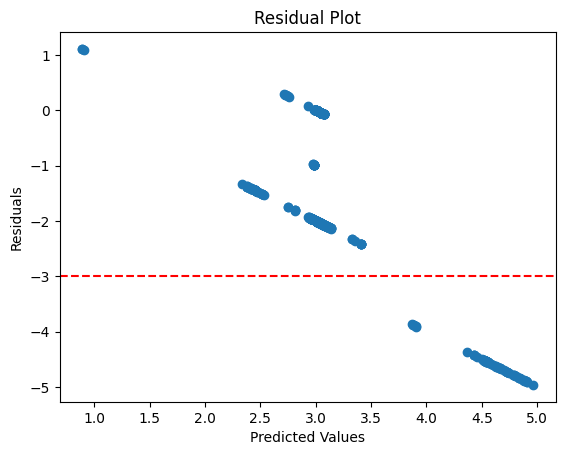

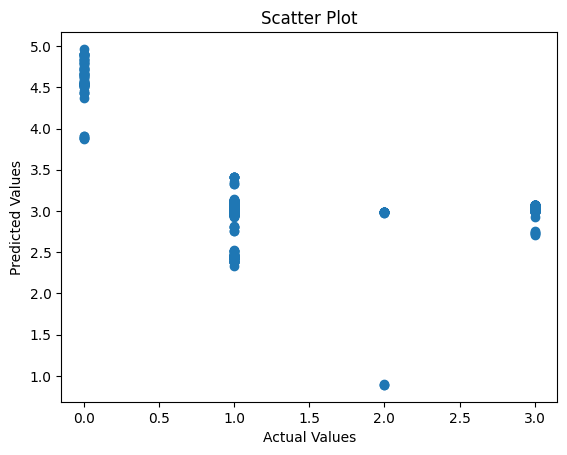

In [ ]:
# 시각화(잔차 플롯, 산점도)
# 잔차 플롯을 위한 잔차 계산(예측값-실제값)
y_test_fit = np.array(y_test).flatten()
pred_fit = np.array(pred).flatten()
residuals = y_test_fit - pred_fit

# 잔차 플롯 그리기
plt.scatter(pred_fit, residuals)
plt.axhline(y=-3, color='r', linestyle='--') # 잔차가 -3인 수평선 추가
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

# 산점도 그리기
plt.scatter(y_test_fit, pred_fit)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Scatter Plot')
plt.show()